In [1]:
##############################################################################################################
# DESCRIPTION: 
# RESULTS:     
#              
##############################################################################################################

In [2]:
######################
# CONFIG & HYPERPARAMS
######################

import os

class HyperParams:
    pass

IMG_PATH = "C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/"

IMG_PATH_VALID = IMG_PATH + "validation/"
IMG_PATH_TEST = IMG_PATH + "test/"
IMG_PATH_TRAIN = IMG_PATH

IMG_PATH_TRAIN = IMG_PATH

hyperparams = HyperParams()
hyperparams.IMG_WIDTH = 64
hyperparams.IMG_HEIGHT = 64
hyperparams.EPOCHS = 200
hyperparams.BATCH_SIZE = 16

hyperparams.NUM_CHANNELS = 32
hyperparams.NUM_RES_BLOCKS = 5

hyperparams.LOSS = 'mean_absolute_error'

IMG_WIDTH = hyperparams.IMG_WIDTH
IMG_HEIGHT = hyperparams.IMG_HEIGHT

IMG_CASE = str(IMG_WIDTH) +  "/0100_1000"
MODEL_NAME = "0100_1000-64-resnet-xh-2"

DEST_TESTS = os.path.abspath(os.path.join('../../../out_tests/', MODEL_NAME))

class RadianceLimits:
    pass
radiance_limits = RadianceLimits()
radiance_limits.noisy_min = 0
radiance_limits.noisy_max = 0.0898
radiance_limits.nitid_min = 0
radiance_limits.nitid_max = 0.3248

from tensorflow.keras.optimizers import Nadam
hyperparams.OPTIMIZER = Nadam(learning_rate=0.0001)

In [3]:
##################
# IMPORTS
##################

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

import numpy as np
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
import os, sys
module_path = os.path.abspath(os.path.join('../../support/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import DatasetUtilsTifF as dsutils
import TrainModelD as train
import ReportsK as reports
import ResnetBatchE as model_factory

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9418581313303370861
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5722079232
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10148022735887767444
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6"
]
Tensorflow version: 2.6.0
Keras Version: 2.6.0
GPU is available


In [5]:
##################
# MODEL DEFINITION
##################

model = model_factory.buildModel(hyperparams)
model.summary()
model.optimizer.get_config()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

{'name': 'Nadam',
 'learning_rate': 0.0001,
 'decay': 0.004,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07}

In [6]:
##################
# PREPARE DATA
##################

train_noisy_files, train_nitid_files, train_noisy, train_nitid = dsutils.readDataset( IMG_PATH_TRAIN, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)
val_noisy_files, val_nitid_files, val_noisy, val_nitid = dsutils.readDataset( IMG_PATH_VALID, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

train_noisy, train_nitid = dsutils.reshapeDataset( train_noisy, train_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )
val_noisy, val_nitid = dsutils.reshapeDataset( val_noisy, val_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT)

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/
Noisy files:8738
Nitid files:8738
Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/validation/
Noisy files:2208
Nitid files:2208


In [7]:
checkpoint_filepath = os.path.abspath(os.path.join('../../../saves/') + MODEL_NAME + "_checkpoint")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [8]:
##################
# TRAIN MODEL
##################
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

hist = train.fit( model, hyperparams, train_noisy, train_nitid, val_noisy, val_nitid, patience = 100, \
                 callbacks = [model_checkpoint_callback] )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6

Epoch 1/200
547/547 [==============================] - 88s 138ms/step - loss: 0.1958 - val_loss: 0.0935
Epoch 2/200
547/547 [==============================] - 74s 136ms/step - loss: 0.0545 - val_loss: 0.0404
Epoch 3/200
547/547 [==============================] - 75s 137ms/step - loss: 0.0463 - val_loss: 0.0384
Epoch 4/200
547/547 [==============================] - 75s 137ms/step - loss: 0.0426 - val_loss: 0.0380
Epoch 5/200
547/547 [==============================] - 75s 138ms/step - loss: 0.0387 - val_loss: 0.0301
Epoch 6/200
547/547 [==============================] - 75s 137ms/step - loss: 0.0363 - val_loss: 0.0294
Epoch 7/200
547/547 [==============================] - 75s 138ms/step - loss: 0.0350 - val_loss: 0.0267
Epoch 8/200
547/547 [==============================] - 75s 137ms/step - loss: 0.0338 - val_loss: 0.0281
Epoch 9/

547/547 [==============================] - 76s 139ms/step - loss: 0.0218 - val_loss: 0.0294
Epoch 155/200
547/547 [==============================] - 76s 140ms/step - loss: 0.0217 - val_loss: 0.0243
Epoch 156/200
547/547 [==============================] - 76s 139ms/step - loss: 0.0216 - val_loss: 0.0224
Epoch 157/200
547/547 [==============================] - 76s 139ms/step - loss: 0.0215 - val_loss: 0.0233
Epoch 158/200
547/547 [==============================] - 76s 139ms/step - loss: 0.0216 - val_loss: 0.0259
Epoch 159/200
547/547 [==============================] - 76s 139ms/step - loss: 0.0216 - val_loss: 0.0243
Epoch 160/200
547/547 [==============================] - 76s 139ms/step - loss: 0.0216 - val_loss: 0.0271
Epoch 161/200
547/547 [==============================] - 76s 139ms/step - loss: 0.0216 - val_loss: 0.0215
Epoch 162/200
547/547 [==============================] - 76s 140ms/step - loss: 0.0216 - val_loss: 0.0228
Epoch 163/200
547/547 [==============================] - 76s

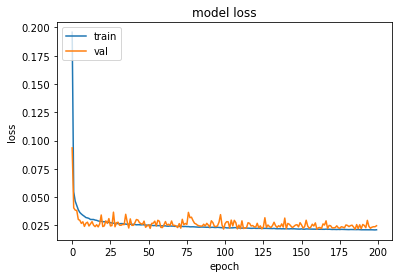

In [9]:
##################
# REPORTS
##################
reports.plotHistory( hist )

In [14]:
model.save(os.path.abspath(os.path.join('../../../saves/', MODEL_NAME)), model)

INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-resnet-xh-2\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [11]:
##################
# PREDICTIONS
##################
ACCURACY_THRESHOLD = 0.01
predictions_metrics, predictions_headers \
    = reports.calcPredictionMetrics( model, val_noisy, val_nitid, ACCURACY_THRESHOLD, \
                                    save_pred = True, save_path = DEST_TESTS, \
                                    noisy_files = val_noisy_files, nitid_files = val_nitid_files, \
                                    max_nitid= radiance_limits.nitid_max  )

Black image found
Black image found
Images count =2208
Best RMSENZ  =2005 (0.91)
Best MAENZ   =2038 (0.92)
Best PSNR    =2005 (0.91)
Best Accuracy=2028 (0.92)
RMSE-NZ  Pred=0.0297  Noisy=0.0943
MAE-NZ   Pred=0.0247  Noisy=0.0903
PSNR     Pred=18.1 dB Noisy=9.4 dB
Accuracy Pred=0.32    Noisy=0.09
SSM      Pred=0.92    Noisy=0.68
HOG MSE  Pred=0.10    Noisy=0.12


In [12]:
reports.saveMetrics( DEST_TESTS, MODEL_NAME, predictions_headers, predictions_metrics )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test/
Noisy files:19
Nitid files:19
Index:0
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_12_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_12_nitid_idx134.tif


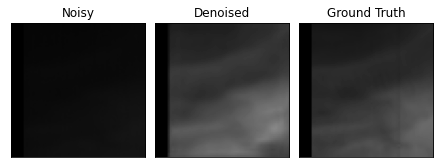

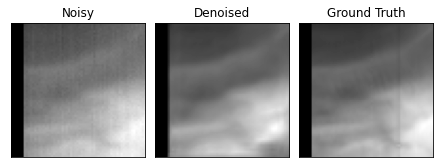

RMSE-NZ  Pred=0.0656  Noisy=0.1722 BEST
MAE-NZ   Pred=0.0578  Noisy=0.1588 BEST
PSNR     Pred=16.1 dB Noisy=7.7 dB BEST
Accuracy Pred=0.08    Noisy=0.00 BEST
SSM      Pred=0.90    Noisy=0.30
HOG MSE  Pred=0.03    Noisy=0.04
******************************************************
Index:1
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_13_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_13_nitid_idx134.tif


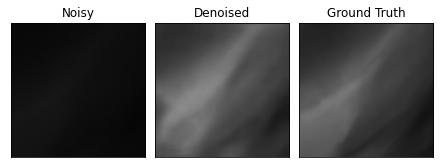

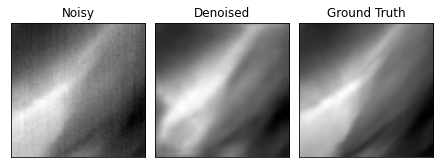

RMSE-NZ  Pred=0.0666  Noisy=0.2105 BEST
MAE-NZ   Pred=0.0627  Noisy=0.1954 BEST
PSNR     Pred=16.9 dB Noisy=6.9 dB BEST
Accuracy Pred=0.01    Noisy=0.00 BEST
SSM      Pred=0.90    Noisy=0.27
HOG MSE  Pred=0.03    Noisy=0.13
******************************************************
Index:2
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_14_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_14_nitid_idx134.tif


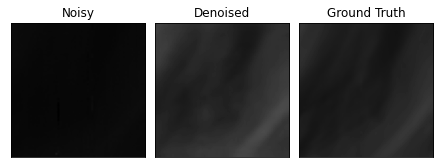

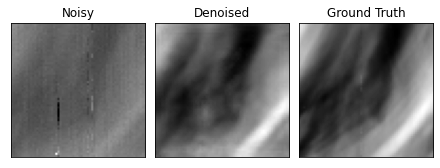

RMSE-NZ  Pred=0.0437  Noisy=0.0994 BEST
MAE-NZ   Pred=0.0414  Noisy=0.0953 BEST
PSNR     Pred=14.1 dB Noisy=7.0 dB BEST
Accuracy Pred=0.00    Noisy=0.00 BEST
SSM      Pred=0.94    Noisy=0.35
HOG MSE  Pred=0.06    Noisy=0.16
******************************************************
Index:3
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_01_00_0_noisy_idx014.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_01_00_0_nitid_idx017.tif


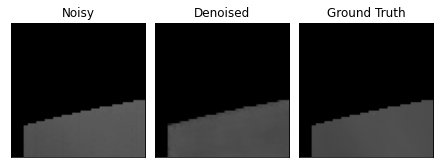

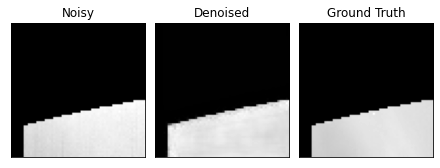

RMSE-NZ  Pred=0.0103  Noisy=0.0388 BEST
MAE-NZ   Pred=0.0053  Noisy=0.0376 BEST
PSNR     Pred=30.5 dB Noisy=19.0 dB BEST
Accuracy Pred=0.85    Noisy=0.00 BEST
SSM      Pred=0.97    Noisy=0.96
HOG MSE  Pred=0.12    Noisy=0.07
******************************************************
Index:4
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0317_03_01_4_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0317_03_01_4_nitid_idx017.tif


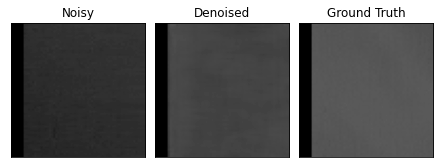

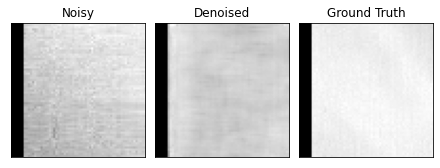

RMSE-NZ  Pred=0.0730  Noisy=0.1632 BEST
MAE-NZ   Pred=0.0698  Noisy=0.1622 BEST
PSNR     Pred=13.9 dB Noisy=6.9 dB BEST
Accuracy Pred=0.05    Noisy=0.00 BEST
SSM      Pred=0.93    Noisy=0.86
HOG MSE  Pred=0.00    Noisy=0.01
******************************************************
Index:5
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0317_03_02_12_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0317_03_02_12_nitid_idx134.tif


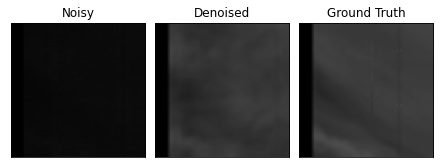

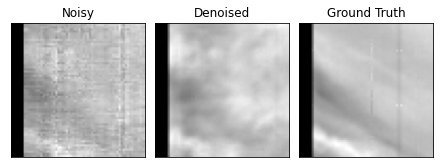

RMSE-NZ  Pred=0.0264  Noisy=0.1870 BEST
MAE-NZ   Pred=0.0216  Noisy=0.1854 BEST
PSNR     Pred=21.2 dB Noisy=4.2 dB BEST
Accuracy Pred=0.26    Noisy=0.00 BEST
SSM      Pred=0.95    Noisy=0.33
HOG MSE  Pred=0.04    Noisy=0.03
******************************************************
Index:6
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0318_03_02_4_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0318_03_02_4_nitid_idx134.tif


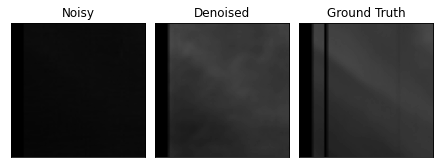

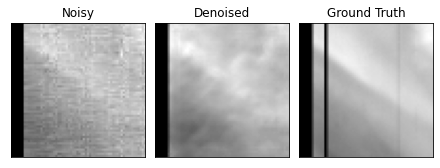

RMSE-NZ  Pred=0.0306  Noisy=0.1704 BEST
MAE-NZ   Pred=0.0158  Noisy=0.1661 BEST
PSNR     Pred=19.5 dB Noisy=4.6 dB BEST
Accuracy Pred=0.48    Noisy=0.00 BEST
SSM      Pred=0.88    Noisy=0.34
HOG MSE  Pred=0.05    Noisy=0.07
******************************************************
Index:7
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0318_03_02_5_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0318_03_02_5_nitid_idx134.tif


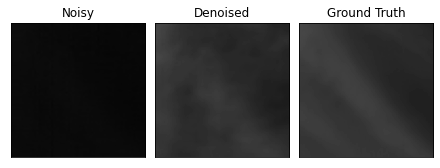

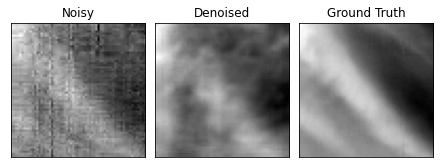

RMSE-NZ  Pred=0.0241  Noisy=0.1649 BEST
MAE-NZ   Pred=0.0191  Noisy=0.1619 BEST
PSNR     Pred=21.3 dB Noisy=4.6 dB BEST
Accuracy Pred=0.35    Noisy=0.00 BEST
SSM      Pred=0.95    Noisy=0.37
HOG MSE  Pred=0.22    Noisy=0.35
******************************************************
Index:8
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0322_03_02_10_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0322_03_02_10_nitid_idx134.tif


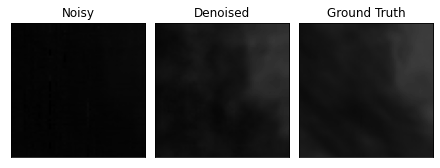

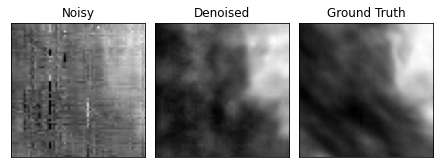

RMSE-NZ  Pred=0.0251  Noisy=0.0964 BEST
MAE-NZ   Pred=0.0217  Noisy=0.0856 BEST
PSNR     Pred=19.5 dB Noisy=7.9 dB BEST
Accuracy Pred=0.20    Noisy=0.00 BEST
SSM      Pred=0.92    Noisy=0.47
HOG MSE  Pred=0.06    Noisy=0.20
******************************************************
Index:9
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0322_04_03_14_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0322_04_03_14_nitid_idx146.tif


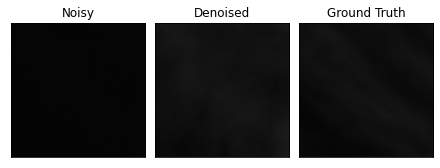

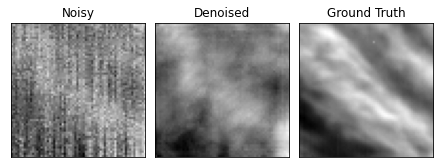

RMSE-NZ  Pred=0.0161  Noisy=0.0368 BEST
MAE-NZ   Pred=0.0137  Noisy=0.0345 BEST
PSNR     Pred=14.5 dB Noisy=7.3 dB BEST
Accuracy Pred=0.37    Noisy=0.05 BEST
SSM      Pred=0.94    Noisy=0.56
HOG MSE  Pred=0.18    Noisy=0.22
******************************************************
Index:10
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0332_00_01_12_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0332_00_01_12_nitid_idx017.tif


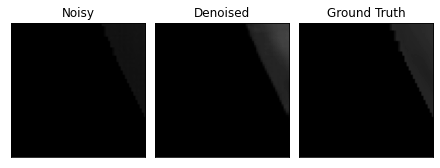

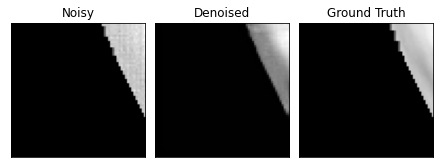

RMSE-NZ  Pred=0.0160  Noisy=0.0366 BEST
MAE-NZ   Pred=0.0058  Noisy=0.0184 BEST
PSNR     Pred=21.2 dB Noisy=14.0 dB BEST
Accuracy Pred=0.90    Noisy=0.74 BEST
SSM      Pred=0.95    Noisy=0.90
HOG MSE  Pred=0.11    Noisy=0.02
******************************************************
Index:11
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0332_00_02_5_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0332_00_02_5_nitid_idx134.tif


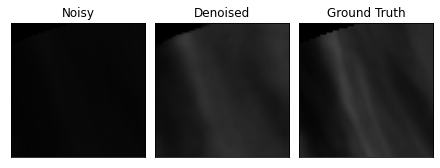

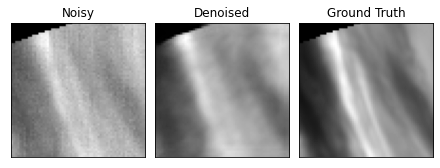

RMSE-NZ  Pred=0.0196  Noisy=0.1089 BEST
MAE-NZ   Pred=0.0155  Noisy=0.0979 BEST
PSNR     Pred=22.2 dB Noisy=7.3 dB BEST
Accuracy Pred=0.39    Noisy=0.01 BEST
SSM      Pred=0.92    Noisy=0.39
HOG MSE  Pred=0.05    Noisy=0.13
******************************************************
Index:12
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0343_03_01_8_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0343_03_01_8_nitid_idx017.tif


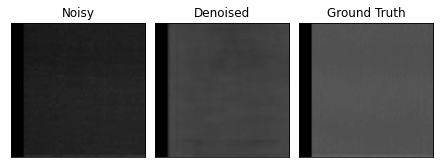

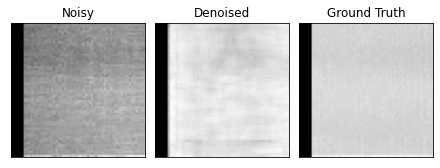

RMSE-NZ  Pred=0.0686  Noisy=0.1952 BEST
MAE-NZ   Pred=0.0651  Noisy=0.1947 BEST
PSNR     Pred=15.1 dB Noisy=6.0 dB BEST
Accuracy Pred=0.06    Noisy=0.00 BEST
SSM      Pred=0.92    Noisy=0.73
HOG MSE  Pred=0.01    Noisy=0.02
******************************************************
Index:13
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_11_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_11_nitid_idx134.tif


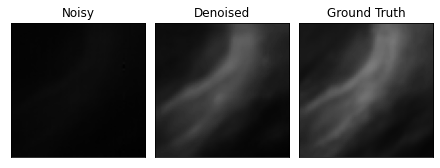

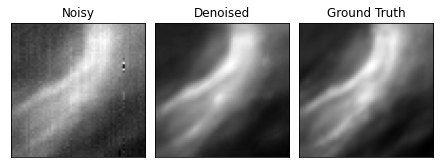

RMSE-NZ  Pred=0.0520  Noisy=0.1931 BEST
MAE-NZ   Pred=0.0473  Noisy=0.1660 BEST
PSNR     Pred=19.4 dB Noisy=8.0 dB BEST
Accuracy Pred=0.03    Noisy=0.00 BEST
SSM      Pred=0.89    Noisy=0.37
HOG MSE  Pred=0.02    Noisy=0.09
******************************************************
Index:14
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_12_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_12_nitid_idx134.tif


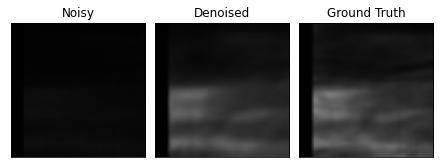

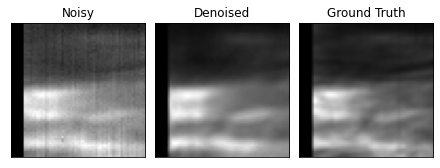

RMSE-NZ  Pred=0.0288  Noisy=0.1742 BEST
MAE-NZ   Pred=0.0217  Noisy=0.1438 BEST
PSNR     Pred=24.7 dB Noisy=9.1 dB BEST
Accuracy Pred=0.31    Noisy=0.00 BEST
SSM      Pred=0.93    Noisy=0.40
HOG MSE  Pred=0.02    Noisy=0.05
******************************************************
Index:15
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_13_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_13_nitid_idx134.tif


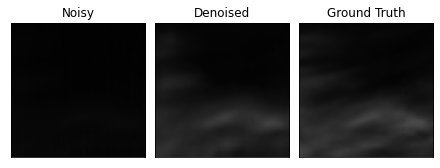

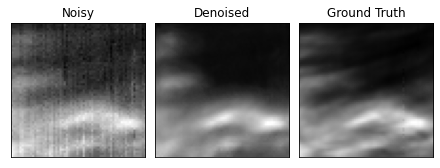

RMSE-NZ  Pred=0.0231  Noisy=0.0979 BEST
MAE-NZ   Pred=0.0181  Noisy=0.0772 BEST
PSNR     Pred=21.9 dB Noisy=9.4 dB BEST
Accuracy Pred=0.37    Noisy=0.04 BEST
SSM      Pred=0.93    Noisy=0.56
HOG MSE  Pred=0.03    Noisy=0.12
******************************************************
Index:16
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_03_11_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_03_11_nitid_idx146.tif


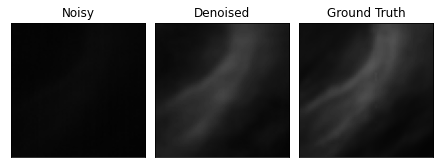

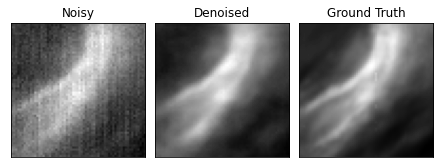

RMSE-NZ  Pred=0.0219  Noisy=0.1221 BEST
MAE-NZ   Pred=0.0168  Noisy=0.1019 BEST
PSNR     Pred=23.7 dB Noisy=8.8 dB BEST
Accuracy Pred=0.39    Noisy=0.02 BEST
SSM      Pred=0.95    Noisy=0.45
HOG MSE  Pred=0.03    Noisy=0.14
******************************************************
Index:17
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_03_8_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_03_8_nitid_idx146.tif


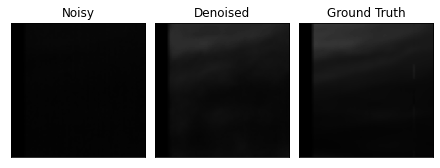

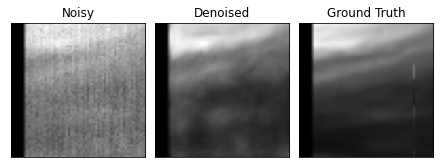

RMSE-NZ  Pred=0.0144  Noisy=0.0710 BEST
MAE-NZ   Pred=0.0105  Noisy=0.0512 BEST
PSNR     Pred=23.8 dB Noisy=10.0 dB BEST
Accuracy Pred=0.59    Noisy=0.21 BEST
SSM      Pred=0.95    Noisy=0.59
HOG MSE  Pred=0.09    Noisy=0.10
******************************************************
Index:18
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_05_02_0_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_05_02_0_nitid_idx134.tif


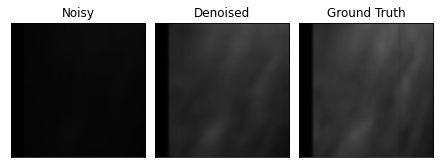

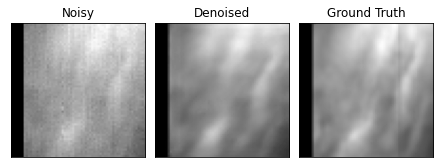

RMSE-NZ  Pred=0.0455  Noisy=0.1835 BEST
MAE-NZ   Pred=0.0422  Noisy=0.1780 BEST
PSNR     Pred=17.6 dB Noisy=5.5 dB BEST
Accuracy Pred=0.09    Noisy=0.00 BEST
SSM      Pred=0.93    Noisy=0.34
HOG MSE  Pred=0.01    Noisy=0.03
******************************************************


In [13]:
test_noisy_files, test_nitid_files, test_noisy, test_nitid = \
    dsutils.readDataset( IMG_PATH_TEST, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

test_noisy, test_nitid = \
    dsutils.reshapeDataset( test_noisy, test_nitid,  hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

test_indexes = np.arange(0,test_noisy.shape[0])

reports.predictByIndexes( model, test_noisy, test_nitid, test_noisy_files, test_nitid_files, test_indexes, ACCURACY_THRESHOLD )